### Here a little toy-GNN which shows how a graph has to be saved before giving it to a GNN ! It just takes graphs in batches, does some convolutions on them to smoothen the features and change the feature dimensionality of the graphs and then does global max pool and hands the result of the pooling to a classifier (obviously doesn't work)

In [59]:
# Load required packages.
import os
import pickle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [60]:
# Function for Visualization of Graphs

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=10.0, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=10.0, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=10.0, zorder=1000)
    plt.axis('off')
    plt.show()

### I just added 16 (pickled) graphs from my Thesis to the repo for demonstration, we can delete it after again.  

In [61]:
# Function for loading pickled objects: 

def load_object(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [62]:
data_dir = 'example_graphs/'

### Show an example graph from my master thesis and what it contains

In [63]:
# So far, I have saved my extracted surface patches as python objects containing all the necessary information about the graph

# Load a random patch
path = os.path.join(data_dir, 'AAAA_GraphPatch.pkl')
patch = load_object(path)
print(patch)

            Number of Nodes: 1049
            Features: (1049, 16)
            Adjacency Matrix: (1049, 1049)
            Edge Weights (Geodesic Distances): (6435, 1)
            Edge Index: (2, 6435)
            Fitness: 1.0
            Coordinates of Points: (1049, 3)
            Mutant Name: AAAA


In [64]:
# 3D coords of all points
patch.coords

array([[-6.3507433,  3.2255063,  9.140162 ],
       [-5.6844487,  2.0924668,  9.008763 ],
       [-5.799665 ,  2.8937101,  9.1833   ],
       ...,
       [11.653854 ,  3.1238155,  2.1397467],
       [11.586424 ,  3.7266395,  2.1782696],
       [11.549943 ,  4.133274 ,  2.028083 ]], dtype=float32)

In [65]:
# Edge index contains information which points are connected by edges
patch.edge_index

array([[   0,    0,    0, ..., 1048, 1048, 1048],
       [   0,    4,    2, ..., 1037, 1046, 1024]], dtype=int64)

In [66]:
# Same info is also in Adjacency matrix
patch.A

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [67]:
# Features of all 1049 nodes
patch.features

array([[0.19275445, 0.69557536, 0.2500831 , ..., 0.6745505 , 0.70408577,
        0.75076044],
       [0.22327161, 0.731156  , 0.23278686, ..., 0.73387176, 0.7631891 ,
        0.70210207],
       [0.21779166, 0.7438569 , 0.21519178, ..., 0.72771114, 0.73821163,
        0.72234356],
       ...,
       [0.34553954, 0.7100434 , 0.24209926, ..., 0.73563176, 0.7057454 ,
        0.5601028 ],
       [0.35729772, 0.73894525, 0.20961805, ..., 0.79894125, 0.73272836,
        0.5887904 ],
       [0.34668663, 0.7444115 , 0.19913045, ..., 0.8133986 , 0.72710276,
        0.6105248 ]], dtype=float32)

In [68]:
# Edge attributes/features/weights the graph might have
patch.edge_weight

array([[0.22761685],
       [0.13859179],
       [0.10394006],
       ...,
       [0.06600717],
       [0.06470193],
       [0.05735583]])

In [77]:
# The label of the graph
patch.fitness

array(1.)

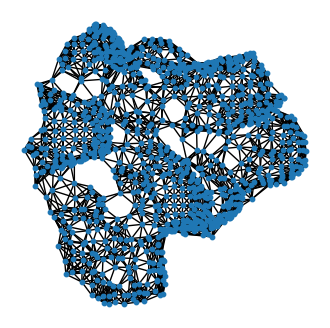

In [69]:
visualize_points(torch.tensor(patch.coords), torch.tensor(patch.edge_index))

### Define Pytorch Customized Dataset for loading data from the data folder

get_item returns an instance of torch_geometric.data.Data class instance. Pytorch geometric needs each graph to be an instance of this class. 

In [70]:
from torch_geometric.data import Dataset
from torch_geometric.data import Data

class PatchDataset(Dataset):

    '''Custom dataset for generation of datasets of graphs extracted from protein surfaces.
    Data_dir should contain instances of the GraphPatch class stored as pkl files with the characters
    0-4 of the filename indicating the mutant name. The function get_item returns an instance of the
    torch_geometric.Data class which contains all information to describe a homogeneous graph:  
    - node features x
    - edge index 
    - edge attributes (edge_weight)
    - label of the graph (fitness level)
    - the 3D-coordinates of all graph nodes'''


    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.mutants = [mutant[0:4] for mutant in os.listdir(data_dir)]

    def __len__(self):
        return len(os.listdir(self.data_dir))

    def __getitem__(self, idx):
        path = os.path.join(self.data_dir, self.mutants[idx]+'_GraphPatch.pkl')
        patch = load_object(path)
        
        x = torch.from_numpy(patch.features)
        edge_index=torch.from_numpy(patch.edge_index)
        edge_weight=torch.from_numpy(patch.edge_weight)
        y=torch.from_numpy(np.asarray(patch.fitness, dtype=np.int64))
        pos=torch.from_numpy(patch.coords)

        return  Data(x, edge_index, edge_weight, y, pos)

In [71]:
# Initialize the Dataset
dataset = PatchDataset(data_dir = data_dir)
len(dataset)

16

In [72]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')


data = dataset[0]  # Get the first graph object.

print()
print('PyTorch Geometric needs each graph as an instance of this "Data" class, which looks like this for the first graph in the dataset')
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print()
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains self-loops: {data.has_self_loops()}')


Dataset: PatchDataset(16):
Number of graphs: 16

PyTorch Geometric needs each graph as an instance of this "Data" class, which looks like this for the first graph in the dataset
Data(x=[1049, 16], edge_index=[2, 6435], edge_attr=[6435, 1], y=1, pos=[1049, 3])

Number of nodes: 1049
Number of node features: 16
Number of edges: 6435
Average node degree: 6.13
Contains self-loops: True


In [73]:
n_train = 12
n_test = 4
batch_size = 4

trainset, testset = torch.utils.data.random_split(dataset, [n_train, n_test])

print(f'Number of training graphs: {len(trainset)}')
print(f'Number of test graphs: {len(testset)}')

Number of training graphs: 12
Number of test graphs: 4


In [74]:
from torch_geometric.loader import DataLoader

trainloader = DataLoader(dataset = trainset, batch_size= batch_size, shuffle = True)
testloader = DataLoader(dataset = testset, batch_size= batch_size, shuffle = True)

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [75]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(16, 16, add_self_loops=False)
        self.conv2 = GCNConv(16, 12, add_self_loops=False)
        self.conv3 = GCNConv(12, 8, add_self_loops=False)
        self.conv4 = GCNConv(8, 5, add_self_loops=False)
        self.lin = Linear(5, 2)            

    def forward(self, x, edge_index, edge_weight, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv4(x, edge_index, edge_weight)

        # 2. Readout layer
        # Take the sum over all nodes in each graph = 16 values per graph
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(16, 16)
  (conv2): GCNConv(16, 12)
  (conv3): GCNConv(12, 8)
  (conv4): GCNConv(8, 5)
  (lin): Linear(in_features=5, out_features=2, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [76]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in trainloader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    loss = train()
    
    train_acc = test(trainloader)
    test_acc = test(testloader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 002, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 003, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 004, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 005, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 006, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 007, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 008, Train Acc: 0.6667, Test Acc: 0.7500
Epoch: 009, Train Acc: 0.6667, Test Acc: 0.7500
